{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

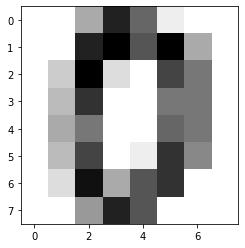

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from torchsummary import summary

digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
digits

In [22]:
n_sample = len(digits.images)
X = digits.images.reshape((n_sample, -1))

# 얘는 평탄화 작업이 필요 없고 결과는 차이 없음.
# X = digits.data.reshape((n_sample, -1))

y = digits.target

In [23]:
# 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # CrossEntropyLoss expects long (정수 클래스 인덱스)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 데이터로더
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
# 데이터 형태 확인
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(y)

X_train shape: torch.Size([1437, 64]), y_train shape: torch.Size([1437])
X_test shape: torch.Size([360, 64]), y_test shape: torch.Size([360])
[0 1 2 ... 8 9 8]


In [26]:
# 🔧 모델 정의 (다중분류용)
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 16)
        self.fc_out = nn.Linear(16, 10)  # 10개의 클래스

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.fc_out(x)  # CrossEntropyLoss expects raw logits
        return x

In [27]:
# 모델, 손실함수, 옵티마이저 정의
model = DigitClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            probs = torch.sigmoid(outputs)
            #predicted = (probs >= 0.5).float() #이건 이진 분류일 때
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/30, Loss: 2.2450, Accuracy: 14.72%
Epoch 2/30, Loss: 1.8690, Accuracy: 62.50%
Epoch 3/30, Loss: 1.1598, Accuracy: 83.61%
Epoch 4/30, Loss: 0.6707, Accuracy: 89.72%
Epoch 5/30, Loss: 0.4237, Accuracy: 91.11%
Epoch 6/30, Loss: 0.3496, Accuracy: 93.06%
Epoch 7/30, Loss: 0.2710, Accuracy: 94.72%
Epoch 8/30, Loss: 0.2396, Accuracy: 95.83%
Epoch 9/30, Loss: 0.2274, Accuracy: 95.56%
Epoch 10/30, Loss: 0.1727, Accuracy: 96.11%
Epoch 11/30, Loss: 0.1712, Accuracy: 96.39%
Epoch 12/30, Loss: 0.1534, Accuracy: 96.67%
Epoch 13/30, Loss: 0.1395, Accuracy: 96.39%
Epoch 14/30, Loss: 0.1154, Accuracy: 96.94%
Epoch 15/30, Loss: 0.1249, Accuracy: 97.22%
Epoch 16/30, Loss: 0.1086, Accuracy: 97.22%
Epoch 17/30, Loss: 0.1038, Accuracy: 96.11%
Epoch 18/30, Loss: 0.1035, Accuracy: 96.67%
Epoch 19/30, Loss: 0.0963, Accuracy: 96.94%
Epoch 20/30, Loss: 0.0800, Accuracy: 96.94%
Epoch 21/30, Loss: 0.0841, Accuracy: 96.67%
Epoch 22/30, Loss: 0.0650, Accuracy: 96.67%
Epoch 23/30, Loss: 0.0808, Accuracy: 97.2

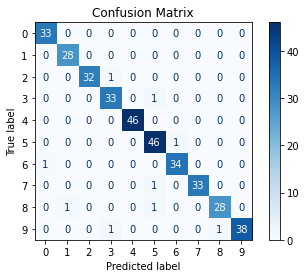


Confusion Matrix:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 32  1  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 1  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  1  0 33  0  0]
 [ 0  1  0  0  0  1  0  0 28  0]
 [ 0  0  0  1  0  0  0  0  1 38]]
Precision (macro): 0.98
Recall (macro): 0.97
F1 Score (macro): 0.97

Classification Report:
              precision    recall  f1-score   support

           0      0.971     1.000     0.985        33
           1      0.966     1.000     0.982        28
           2      1.000     0.970     0.985        33
           3      0.943     0.971     0.957        34
           4      1.000     1.000     1.000        46
           5      0.939     0.979     0.958        47
           6      0.971     0.971     0.971        35
           7      1.000     0.971     0.985        34
           8      0.966     0.933     0.949        30
           9     

In [29]:
# 모델 평가
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)  # logits
        predicted = torch.argmax(outputs, dim=1)  # 예측 클래스
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 혼동 행렬
conf_matrix = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 평가 지표
f1 = f1_score(all_labels, all_predictions, average='macro')  # 'macro': 클래스별 평균
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f'\nConfusion Matrix:\n{conf_matrix}')
print(f'Precision (macro): {precision:.2f}')
print(f'Recall (macro): {recall:.2f}')
print(f'F1 Score (macro): {f1:.2f}')

# 전체 리포트 출력
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, digits=3))

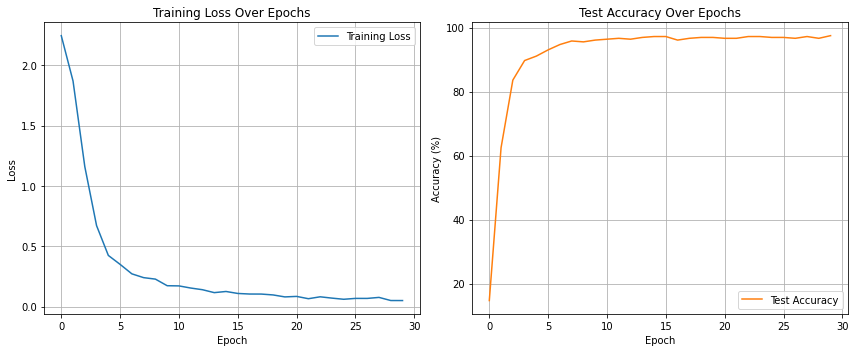

In [30]:
# 손실과 정확도 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()